## Imports

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

## Loading the data

In [2]:
twitter = pd.read_csv('../data/english_tweets.csv')

In [3]:
reddit = pd.read_csv('../data/reddit_clean.csv', low_memory=False)

## Cleaing the `twitter` dataframe

In [4]:
twitter.head()

,id,permalink,username,to,text,date,retweets,favorites,mentions,hashtags,geo
0,1260652847521128448,https://twitter.com/jorge03568721/status/12606...,jorge03568721,NaN,Coronavirus: The lost six weeks when US failed...,2020-05-13 19:27:15+00:00,0,0,NaN,NaN,NaN
1,1260652847290413057,https://twitter.com/brainboredcom/status/12606...,brainboredcom,NaN,California doctor says arthritis drug improved...,2020-05-13 19:27:15+00:00,0,0,NaN,NaN,NaN
2,1260652846472560640,https://twitter.com/Mama_Crabcakes/status/1260...,Mama_Crabcakes,RandPaul,We already knew that we were team coronavirus/...,2020-05-13 19:27:15+00:00,0,0,NaN,NaN,NaN
3,1260652846279606272,https://twitter.com/MuhammadAyub218/status/126...,MuhammadAyub218,NaN,How companies and employees can make their bes...,2020-05-13 19:27:15+00:00,0,0,@wef,NaN,NaN
4,1260652846225055744,https://twitter.com/_ResourceX/status/12606528...,_ResourceX,NaN,COVID-19 is a budget nightmare for #localgov. ...,2020-05-13 19:27:14+00:00,0,0,NaN,#localgov #PBBi,NaN


In [5]:
# Add origin column
twitter.loc[:, 'origin'] = 'twitter'

In [6]:
# Remove all columns except origin and text
cols_to_keep = ['origin', 'text']
twitter = twitter.loc[:, cols_to_keep]

In [7]:
# Check for nulls
twitter.isnull().sum()

origin    0
text      0
dtype: int64

## Cleaning the `reddit` dataframe

In [8]:
reddit.head()

,subreddit,subreddit_subscribers,title,selftext,score,num_comments,author,created_utc,date
0,CoronaVirusPA,5,Pennsylvania resident released from quarantine...,NaN,1,6,rfwaverider,1582989404,2020-02-29
1,CoronaVirusPA,18,Allegheny county briefing on coronavirus,NaN,1,0,rb30zk,1583178566,2020-03-02
2,CoronaVirusPA,18,PA couple kept in TX quarantine,NaN,1,0,rb30zk,1583178657,2020-03-02
3,CoronaVirusPA,18,Philly Inquirer thinks virus might never reach...,NaN,1,0,rb30zk,1583178823,2020-03-02
4,CoronaVirusPA,18,Penn State NOT recommending preparedness,NaN,1,1,rb30zk,1583178905,2020-03-02


In [9]:
# Remove all columns except subreddit and title
cols_to_keep = ['subreddit', 'title']
reddit = reddit.loc[:, cols_to_keep]

In [10]:
# Rename columns to match twitter dataframe
reddit.rename(columns={
    'subreddit': 'origin',
    'title': 'text',
}, inplace=True)

In [11]:
# Keep only posts from /r/Coronavirus
is_coronavirus_sub = reddit['origin'] == 'CoronavirusUS'
reddit = reddit.loc[is_coronavirus_sub, :]

In [12]:
# Check for nulls
reddit.isnull().sum()

origin    0
text      0
dtype: int64

In [13]:
# Trim reddit df to be same size as twitter df
reddit = reddit.sample(n=twitter.shape[0], random_state=42)

## Creating a combined dataframe

In [14]:
df = pd.concat([reddit, twitter])

In [15]:
df.head()

,origin,text
33326,CoronavirusUS,ICU doctor fighting coronavirus denied green card
29967,CoronavirusUS,Reports suggest many have had coronavirus with...
29128,CoronavirusUS,GET TESTED WITHOUT LEAVING YOUR HOUSE
20728,CoronavirusUS,Will I Recieve a Check?
9737,CoronavirusUS,Some kids only eat at school


In [16]:
df.shape

(11904, 2)

## Train/test split

In [17]:
X = df['text']
y = df['origin']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Logistic Regression

In [18]:
logreg_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear')),
])

logreg_pipe_params = {
    'cvec__max_df': [0.4, 0.6, 0.8],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.01, 0.1, 1],
    'logreg__penalty': ['l1', 'l2'],
}

In [19]:
logreg_gs = GridSearchCV(logreg_pipe,
                         logreg_pipe_params,
                         cv=5)

In [20]:
logreg_gs.fit(X_train, y_train);

In [21]:
print('Train score:', round(logreg_gs.score(X_train, y_train), 4))
print('Test score:', round(logreg_gs.score(X_test, y_test), 4))
print('Baseline accuracy:', round(y.value_counts(normalize=True)[0], 4))

Train score: 0.9957
Test score: 0.8851
Baseline accuracy: 0.5


## Multinomial Naive Bayes

In [22]:
mnb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

mnb_pipe_params = {
    'cvec__max_df': [0.4, 0.6, 0.8],
    'cvec__ngram_range': [(1, 1), (1, 2)],
}

In [23]:
mnb_gs = GridSearchCV(mnb_pipe,
                      mnb_pipe_params,
                      cv=5)

In [24]:
mnb_gs.fit(X_train, y_train);

In [25]:
print('Train score:', round(mnb_gs.score(X_train, y_train), 4))
print('Test score:', round(mnb_gs.score(X_test, y_test), 4))
print('Baseline accuracy:', round(y.value_counts(normalize=True)[0], 4))

Train score: 0.9028
Test score: 0.796
Baseline accuracy: 0.5


## Random Forest

In [26]:
rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

rf_pipe_params = {
    'cvec__max_df': [0.4, 0.6, 0.8],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [None, 2, 3],
}

In [27]:
rf_gs = GridSearchCV(rf_pipe,
                     rf_pipe_params,
                     cv=5)

In [28]:
rf_gs.fit(X_train, y_train);

In [29]:
print('Train score:', round(rf_gs.score(X_train, y_train), 4))
print('Test score:', round(rf_gs.score(X_test, y_test), 4))
print('Baseline accuracy:', round(y.value_counts(normalize=True)[0], 4))

Train score: 0.9999
Test score: 0.8579
Baseline accuracy: 0.5


## Examining the logistic regression model

In [30]:
# View which parameters were best
logreg_gs.best_params_

{'cvec__max_df': 0.4,
 'cvec__ngram_range': (1, 2),
 'logreg__C': 1,
 'logreg__penalty': 'l2'}

In [31]:
# Get words used in the model
words = logreg_gs.best_estimator_.named_steps['cvec'].get_feature_names()

# Get associated coefficients of words used
coefficients = logreg_gs.best_estimator_.named_steps['logreg'].coef_

# Create data frame out of words and their coefficients
coef_df = pd.DataFrame({
    'features': words,
    'coefs': coefficients[0]
})

In [32]:
# Show words most predictive of Reddit
coef_df.sort_values('coefs').head(10)

,features,coefs
23870,coronavirus covid,-2.356449
23917,coronavirus disease,-1.197954
93823,the us,-1.120434
1197,19 coronavirus,-1.098492
89919,symptoms,-1.054766
101484,usa,-1.031670
25389,covid 19,-0.997221
65779,nurse,-0.955586
65915,nyc,-0.933601
59880,medical,-0.926124


In [35]:
# Show words most predictive of Twitter
coef_df.sort_values('coefs', ascending=False).head(10)

,features,coefs
25385,covid,5.264099
26035,covid_19,2.993633
23706,coronavirus,2.664431
47035,https,2.548196
46944,http,2.509174
26145,covidー19,1.571366
102465,via,1.473584
101762,utheni,1.317409
55774,level3lockdown,1.216644
100000,uk,1.163025


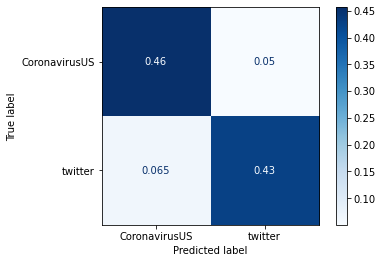

In [34]:
# View what our model was most likely to get wrong
plot_confusion_matrix(logreg_gs.best_estimator_, X_test, y_test, normalize='all', cmap='Blues');